#__02-620 HW4 Programming - Image classification using Pytorch__

In this last homework, we will learn basic deep learning. Deep learning is a fast moving research area. There is ongoing research on why it works so well, but so far the theory of deep learning is still building in progress. Due to this nature of the field, hands-on experience is the most important in deep learning.

We will use Pytorch, one of the popular deep learning frameworks. If you are unfamiliar with the Pytorch, please watch the recitation video and look at the recitation material, where we covered basic understanding of Pytorch.

Because our course is an introductory machine learning course, we covered broad topics in machine learning and thus we can't go very deep into deep learning. So we will go through only the basics of deep learning. Throughout the homework, we hope you'll get familiar with deep learning and Pytorch framework.

Referenced 16-720 and 16-824, great courses in CMU

In [11]:
#Feel free to import any required library you need.
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor, Compose, Resize, RandomRotation, Normalize
from torch.optim.lr_scheduler import ReduceLROnPlateau

import matplotlib.pyplot as plt
import os, pickle, time
import pandas as pd
import numpy as np
from PIL import Image
torch.manual_seed(0) #For reproducibility

device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

#__General Task description__

In this assignment, our task is to build a workflow of classifying the objects using deep learning models. The dataset we are interested in is CIFAR10(https://www.cs.toronto.edu/~kriz/cifar.html). This dataset includes 60,000 32x32 color images in 10 clases. It has 50,000 training samples and 10,000 test samples. You can download the dataset using torchvision.datasets.CIFAR10()

__TODOs__
1. Change path to your desired path!!!
2. Once you download your data, you can change it to False

In [3]:
your_path='./data'
download=True
train_transform = Compose([
    Resize((256)),
    ToTensor(),
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transform = Compose([
    Resize((256)),
    ToTensor(),
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
trainset = torchvision.datasets.CIFAR10(root=your_path, train=True, download=download, transform = train_transform)
testset = torchvision.datasets.CIFAR10(root=your_path, train=False, download=download, transform = test_transform)


Files already downloaded and verified
Files already downloaded and verified


#__Task 1 Build your own DataLoader(10 Points)__

As we covered in the recitation, Pytorch uses the DataLoader class to bring datapoints to the neural network. You can do any preprocessing in this step.

Take a look at https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

There can be possibility that you don't have enough dataset. In this case, we can populate the dataset using data augmentation. For example, in Computer Vision, one way to augment your data is adding rotated images.

BE CAREFUL: In Pytorch, one of the argument in the DataLoader is indicating train or test. This is very important argument because you do data augmentation with training samples, but not with test samples. You should consider this when you implement DataLoader.

Tip:
1. It is very important to understand what is your data and how they are organized. Observe how folder and files strutured in the downloaded CIFAR10. See the annotation files, open the images, try to see if there is any pattern in file name, etc.
2. For data augmentation, feel free to use methods in torchvision.transforms

__TODOs__
1. Form your own DataLoader
2. In the __getitem__, add your own data augmentation.
3. You should have an variable that controls size of the image. For this assignment, use size of 256: that is, image should be (256, 256, 3). Please be mind that when you load this image to the Tensor, it might be changed to (3, 256, 256)

In [5]:
class CIFAR10Dataset(Dataset):
    def __init__(self, root, train = True, transform=None):
        self.root = root
        self.transform = transform
        self.train = train
        
        self.data = []
        self.targets = []
        self.InitData()
        self.metadata = {}
        self.class_to_idx = {}
        self.InitMetaData()

    def InitMetaData(self):
        file_path = os.path.join(self.root, 'cifar-10-batches-py/batches.meta')
        with open(file_path, 'rb') as f:
            self.metadata = pickle.load(f, encoding='latin1')
        for i, key in enumerate(self.metadata['label_names']):
            self.class_to_idx[key] = i

    def InitData(self):
        if self.train == True:
            for i in range(1, 6):
                file_path = os.path.join(self.root, f'cifar-10-batches-py/data_batch_{i}')
                with open(file_path, 'rb') as f:
                    batch = pickle.load(f, encoding='latin1')
                    self.data.append(batch['data'])
                    self.targets.extend(batch['labels'])
            self.data = np.vstack(self.data)
        elif self.train == False:
            file_path = os.path.join(self.root, f'cifar-10-batches-py/test_batch')
            with open(file_path, 'rb') as f:
                batch = pickle.load(f, encoding='latin1')
                self.data = batch['data']
                self.targets.extend(batch['labels'])
        
        self.data = self.data.reshape((-1, 3, 32, 32))
        self.data = self.data.transpose((0, 2, 3, 1))

    def __getitem__(self, idx):
        img = self.data[idx]
        img = Image.fromarray(img)
        if self.transform:
            img = self.transform(img)
        target = self.targets[idx]
        return img, target

    def __len__(self):
        return len(self.data)

In [6]:
train_transform = Compose([
    Resize((256)),
    ToTensor(),
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    
])

test_transform = Compose([
    Resize((256)),
    ToTensor(),
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [7]:
# CANNOT USE THESE ON WINDOWS LOCAL MACHINE BECAUSE JUPYTER NOTEBOOKS DON'T SUPPORT MULTITHREADING. AHHHHHHHHHHHHHHHH!!!!!!!!!!
trainset1 = CIFAR10Dataset(root=your_path, train=True, transform = train_transform)
testset1 = CIFAR10Dataset(root=your_path, train=False, transform = test_transform)
trainloader = torch.utils.data.DataLoader(trainset1, batch_size = 64, shuffle = True, num_workers=4)
trainloader = torch.utils.data.DataLoader(testset1, batch_size = 64, shuffle = False, num_workers=4)

Now you should be able to bring and use your Dataloader

In [8]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=4)

#__Task 2 Build Neural Network(5 Points)__

If you look at some of the deep learning papers, they provide their model architecture, which is how they organized their neural network. Through this task, you should be able to rebuild the neural network given model architecture.
The model we are interested in is AlexNet(https://arxiv.org/abs/1404.5997). For simplicity, we are going to implement a slightly simplified version.


This is the model you should rebuild:

AlexNet(

  (features): Sequential(
  
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace))
  
  (classifier): Sequential(
  
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (3): ReLU(inplace)
    (4): Conv2d(256, 20, kernel_size=(1, 1), stride=(1, 1)))
)


__TODO: Implement the model architcture__

In [9]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        #TODO: Define Features
        self.features=nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2)),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size=(3, 3), stride=(2, 2), dilation=(1, 1), ceil_mode=False),
            nn.Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
            nn.ReLU(inplace= True),
            nn.MaxPool2d(kernel_size=(3, 3), stride=(2, 2), dilation=(1, 1), ceil_mode=False),
            nn.Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace= True),
            nn.Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace= True),
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace= True)
        )
        
        #TODO: Define Classifiers
        self.classifier=nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1)),
            nn.ReLU(inplace = True),
            nn.Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1)),
            nn.ReLU(inplace = True),
            nn.Conv2d(256, 10, kernel_size=(1, 1), stride=(1, 1))
        )
        
        #We will give this initialization for you
        for neuron in self.features:
            if isinstance(neuron,nn.Conv2d):
                nn.init.xavier_uniform_(neuron.weight)
        
        
    def forward(self, x):
        #TODO: Define forward pass
        x = self.features(x)
        x = self.classifier(x)
        
        return x
model = AlexNet().to(device)

Using cuda device


#__Task 3 Build deep learning pipeline(20 Points)__

You have Dataset, DataLoader, and your model. It's time to make a pipeline with ingredients. In the recitation, we covered that before we build a training loop, we need to define loss and optimizer. Due to the limited time, we will provide you with loss and optimizer. Use the given parameters.

In [10]:
#Do not change this cell
num_iter=20
loss_fn=nn.BCELoss()
optimizer=torch.torch.optim.SGD(model.parameters(),lr=0.1)
scheduler = ReduceLROnPlateau(optimizer, 'min')

Now, build a deep learning pipeline. 

__TODOs: Finish the pipeline. Bring your DataLoader and the model here. Organize the train loop and test loop, and then train and test your model. At the end of the pipeline, your pipeline should be able to provide graphs of training accuracy, test accuracy and training loss, and report final test accuracy. If you implement it well, your test accuracy should be around 65%.__

__IMPORTANT: After you get predictions from your model, please add below codes before you put the prediction into loss function. Remember below lines should be added in both training loop and test loop!__

        (assume you used pred=model(X))
        '''
        final_layer=nn.MaxPool2d((pred.size(2),pred.size(3)))
        pred=final_layer(pred)
        pred=torch.reshape(pred,(-1,10))#(-1,10)
        pred=F.sigmoid(pred)
        '''
        Then loss(pred,y) and goes on

In [11]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    train_loss, correct = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y_one_hot = torch.nn.functional.one_hot(y, num_classes = 10)
        y_one_hot = y_one_hot.to(device).float()
        
        # Compute prediction error
        pred = model(X)

        final_layer=nn.MaxPool2d((pred.size(2),pred.size(3)))
        pred=final_layer(pred)
        pred=torch.reshape(pred,(-1,10))#(-1,10)
        pred=F.sigmoid(pred)

        loss = loss_fn(pred, y_one_hot)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()       

        if batch % 100 == 0:
            loss_, current = loss.item(), (batch + 1) * len(X)
            print(f"\rloss: {loss_:>7f}  [{current:>5d}/{size:>5d}]", end = '')
            
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        train_loss += loss.item()

    train_loss /= num_batches
    correct /= size
    return correct, train_loss

In [12]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_one_hot = torch.nn.functional.one_hot(y, num_classes = 10)
            y_one_hot = y_one_hot.to(device).float()
            pred = model(X)

            final_layer=nn.MaxPool2d((pred.size(2),pred.size(3)))
            pred=final_layer(pred)
            pred=torch.reshape(pred,(-1,10))#(-1,10)
            pred=F.sigmoid(pred)

            test_loss += loss_fn(pred, y_one_hot).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            
    test_loss /= num_batches
    correct /= size
    print(f"\rTest Error: \t Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct, test_loss

In [12]:
record_dict = {
    'train_accuracy': [],
    'train_loss': [],
    'test_accuracy': [],
    'test_loss': []
}

for t in range(num_iter):
    print(f"Epoch {t+1}\n-------------------------------")
    tr_accuracy, tr_loss = train(trainloader, model, loss_fn, optimizer)
    record_dict['train_accuracy'].append(tr_accuracy)
    record_dict['train_loss'].append(tr_loss)

    ts_accuracy, ts_loss = test(testloader, model, loss_fn)
    record_dict['test_accuracy'].append(ts_accuracy)
    record_dict['test_loss'].append(ts_loss)
    
    scheduler.step(ts_loss)

    torch.save(record_dict, './data/record.pt')
    torch.save(model.state_dict(), './data/model.pt')
    torch.save(optimizer.state_dict(), './data/optimizer.pt')
    
print("Done!")

Epoch 1
-------------------------------
Test Error: 	 Accuracy: 16.4%, Avg loss: 0.324695 

Epoch 2
-------------------------------
Test Error: 	 Accuracy: 23.6%, Avg loss: 0.297737 

Epoch 3
-------------------------------
Test Error: 	 Accuracy: 18.5%, Avg loss: 0.319152 

Epoch 4
-------------------------------
Test Error: 	 Accuracy: 28.6%, Avg loss: 0.280695 

Epoch 5
-------------------------------
Test Error: 	 Accuracy: 26.2%, Avg loss: 0.287800 

Epoch 6
-------------------------------
Test Error: 	 Accuracy: 28.6%, Avg loss: 0.275549 

Epoch 7
-------------------------------
Test Error: 	 Accuracy: 40.8%, Avg loss: 0.251146 

Epoch 8
-------------------------------
Test Error: 	 Accuracy: 37.1%, Avg loss: 0.262319 

Epoch 9
-------------------------------
Test Error: 	 Accuracy: 36.5%, Avg loss: 0.272324 

Epoch 10
-------------------------------
Test Error: 	 Accuracy: 43.8%, Avg loss: 0.245057 

Epoch 11
-------------------------------
Test Error: 	 Accuracy: 44.8%, Avg los

In [2]:
def PlotCurvesTrainTest(y_train, y_test, labels, title, y_label, save_path = None):
    fig = plt.figure()
    axs = fig.subplots(1,1)
    xticks = range(1, 1+len(y_train))
    axs.plot(xticks, y_train, color = 'blue', label = labels[0])
    axs.plot(xticks, y_test, color = 'orange', label = labels[1])
    axs.legend()
    axs.set_xlabel('Epoch')
    axs.set_ylabel(y_label)
    axs.set_title(title)
    axs.set_xticks(xticks)
    fig.tight_layout()
    if save_path is not None:
        fig.savefig(save_path)

Final Loss is  61.2%


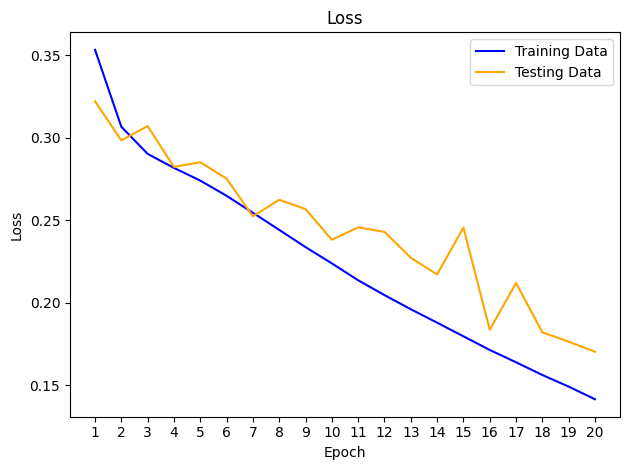

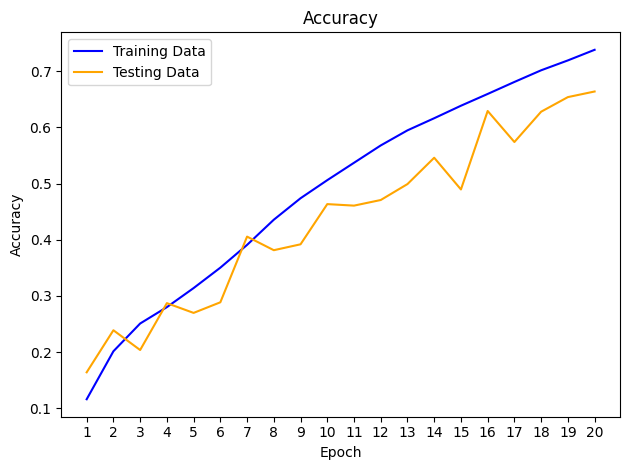

In [15]:
records = torch.load('./data/trained_models/record_final.pt')
PlotCurvesTrainTest(records['train_loss'], records['test_loss'], ['Training Data', 'Testing Data'], 'Loss', 'Loss', './images/TrainingLoss.png' )
PlotCurvesTrainTest(records['train_accuracy'], records['test_accuracy'], ['Training Data', 'Testing Data'], 'Accuracy', 'Accuracy', './images/TrainingAccuracy.png')
print(f'Final Loss is {61.2: 0.1f}%')

#__Task 4 Weight transfer(Transfer learning)(5 Points)__

There can be two possible scenarios when you are given neural network architcture: One is build everything entirely from the scratch, as you implemented above, and the other is using the pretrained model. The former is preferred when there is no pretrained model or you are training with novel(or unpopular) dataset. The latter is generally more preferred, especially if you are working in computer vision or natural langauge processing related area, because most of the pretrained neural network works very well and their pretrained dataset is very large scale such that starting from raw training might consume great amount of time. For the latter case, it's just one line of code:

In [14]:
#model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True) #DO NOT USE THIS CODE IN THIS ASSIGNMENT

In this task, we will slightly tweak: You will not use the above code to bring a pretrained model. Instead, you will transfer the weights of the pretrained model to the model you built above. Knowing this will help you later when you want to build your own model but basic flow comes from previous existing models.

One thing you should know, and should remember for your future is that Pytorch stores trained weights as a dictionary data structure, the key and value, and their name of the key has a pattern such that you can easily load your desired key and corresponding weights.


If your implementation is correct, your final accuracy should be around 80%


__TODOs: Implement below weight transfer function. Then train and test your pretrained model.Provide graphs of training accuracy, test accuracy and training loss. Report final accuracy__

In [19]:
from torchvision._internally_replaced_utils import load_state_dict_from_url # This is the hint!

def Load_Alexnet_Weight_Transferred(pretrained=True, **kwargs):
    r"""AlexNet model architecture from the
    `"One weird trick..." <https://arxiv.org/abs/1404.5997>`_ paper.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model_urls = {
            'alexnet': 'https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth',
    }    
    device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
    model_2 = AlexNet().to(device)
    #TODO: Initialize weights correctly based on whethet it is pretrained or not
    if pretrained:
        #Your code herestatedict = model_2.state_dict()
        statedict = torch.hub.load_state_dict_from_url(model_urls['alexnet'], progress = 'True')
        keys = list(statedict.keys())
        
        for key in keys:
            if key not in model_2.state_dict() or statedict[key].shape != model_2.state_dict()[key].shape:
                del statedict[key]
        model_2.load_state_dict(statedict, strict = False)                    

    return model_2

model_pretrained = Load_Alexnet_Weight_Transferred(pretrained=True)

In [27]:
a = {1: 'hi', 2: 'me'}
keys = a.keys()
# for key in keys:
#     del a[key]
print(list(a.keys()))

[1, 2]


In [16]:
loss_fn=nn.BCELoss()
optimizer=torch.torch.optim.SGD(model_pretrained.parameters(),lr=0.1)
scheduler = ReduceLROnPlateau(optimizer, 'min')

In [17]:
#Use your previous training and test loops, but don't forget to use above model
record_dict = {
    'train_accuracy': [],
    'train_loss': [],
    'test_accuracy': [],
    'test_loss': []
}
for t in range(num_iter):
    print(f"Epoch {t+1}\n-------------------------------")
    tr_accuracy, tr_loss = train(trainloader, model_pretrained, loss_fn, optimizer)
    record_dict['train_accuracy'].append(tr_accuracy)
    record_dict['train_loss'].append(tr_loss)
    ts_accuracy, ts_loss= test(testloader, model_pretrained, loss_fn)
    record_dict['test_accuracy'].append(ts_accuracy)
    record_dict['test_loss'].append(ts_loss)
    scheduler.step(ts_loss)

    torch.save(record_dict, './data/pretrain_record.pt')
    torch.save(model_pretrained.state_dict(), './data/pretrain_model.pt')
    torch.save(optimizer.state_dict(), './data/optimizer.pt')

print("Done!")

Epoch 1
-------------------------------
Test Error: 	 Accuracy: 44.7%, Avg loss: 0.239841 

Epoch 2
-------------------------------
Test Error: 	 Accuracy: 58.6%, Avg loss: 0.203177 

Epoch 3
-------------------------------
Test Error: 	 Accuracy: 64.0%, Avg loss: 0.178146 

Epoch 4
-------------------------------
Test Error: 	 Accuracy: 70.8%, Avg loss: 0.152640 

Epoch 5
-------------------------------
Test Error: 	 Accuracy: 66.5%, Avg loss: 0.168720 

Epoch 6
-------------------------------
Test Error: 	 Accuracy: 65.8%, Avg loss: 0.186236 

Epoch 7
-------------------------------
Test Error: 	 Accuracy: 78.8%, Avg loss: 0.119002 

Epoch 8
-------------------------------
Test Error: 	 Accuracy: 79.5%, Avg loss: 0.115509 

Epoch 9
-------------------------------
Test Error: 	 Accuracy: 80.4%, Avg loss: 0.117297 

Epoch 10
-------------------------------
Test Error: 	 Accuracy: 75.6%, Avg loss: 0.143026 

Epoch 11
-------------------------------
Test Error: 	 Accuracy: 82.3%, Avg los

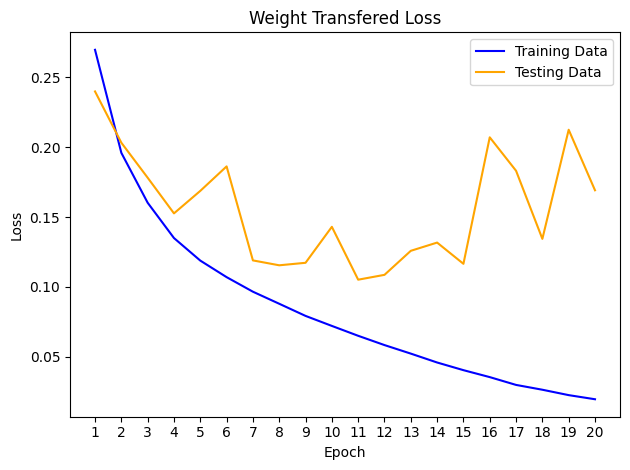

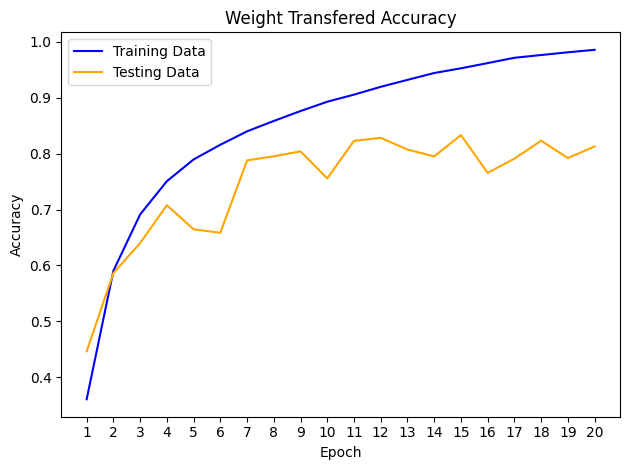

In [29]:
records = torch.load('./data/trained_models/pretrain_record_final.pt')

PlotCurvesTrainTest(records['train_loss'], records['test_loss'], ['Training Data', 'Testing Data'], 'Weight Transfered Loss', 'Loss', './images/WTTrainingLoss.png')
PlotCurvesTrainTest(records['train_accuracy'], records['test_accuracy'], ['Training Data', 'Testing Data'], 'Weight Transfered Accuracy', 'Accuracy', './images/WTTrainingAccuracy.png')

#__Task 5 Evaluate your model(10 Points)__

You have a full loop of both train and test. Let's see how good your model is. In the lecture, we learned precision, recall. In addition to these metrics, one way to visualize our model performance is to show a heatmap of classification result. You need to build a (# classes)x(# classes) matrix. Then, for each sample in the test set with a true label ith class, we can get jth class through your model. Then we add a value to matrix[i][j], then we normalize the matrix. By doing so, we can visually show our performance. Remember that in CIFAR10, we have 10 classes. 

__TODOs__
1. Visualize the heatmap, and report which class showed most accurate, and which 'task' showed most mistakes, i.e, predicted j when the true label is i.
2. Provide 3 cases of failed prediction with most mistakes 'task'. So you should show a total of 6 images here. Briefly write why you think the model can't predict well.

In [13]:
#Your code here
model = AlexNet().to(device)
model.load_state_dict(torch.load('./data/trained_models/model_final.pt'))
model2 = AlexNet().to(device)
model2.load_state_dict(torch.load('./data/trained_models/pretrain_model_final.pt'))

<All keys matched successfully>

In [14]:
def GetPredictions(model, dataloader):
    target_prob = [] # List to hold predictions
    full_pred = [] # list to hold images of Final "layer" 
    model.eval()
    with torch.no_grad():
        for X, y in testloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            full_pred.extend(pred)
            final_layer=nn.MaxPool2d((pred.size(2),pred.size(3)))
            pred=final_layer(pred)
            pred=torch.reshape(pred,(-1,10))#(-1,10)
            pred=F.sigmoid(pred)
            target_prob.append(pred)
    target_prob = torch.vstack(target_prob)
    return target_prob, full_pred

In [15]:
target_prob, full_pred = GetPredictions(model, testloader)
pretrain_target_prob, pretrain_full_pred = GetPredictions(model2, testloader)

In [16]:
predicted_targets = target_prob.argmax(1).tolist()
pretrain_predicted_targets = pretrain_target_prob.argmax(1).tolist()
true_targets = testset.targets

In [17]:
num_targets = len(testset.class_to_idx)
num_samples = len(testset)

heatmap_arr = np.zeros((num_targets, num_targets))
num_iter = 0
for i, j in zip(true_targets, predicted_targets):
    num_iter += 1
    heatmap_arr[i,j] += 1
heatmap_arr /= heatmap_arr.sum(axis = 1)[:, np.newaxis]

pretrain_heatmap_arr = np.zeros((num_targets, num_targets))
num_iter = 0
for i, j in zip(true_targets, pretrain_predicted_targets):
    num_iter += 1
    pretrain_heatmap_arr[i,j] += 1
pretrain_heatmap_arr /= pretrain_heatmap_arr.sum(axis = 1)[:, np.newaxis]

In [18]:
idx_to_class = {}
for key, val in testset.class_to_idx.items():
    idx_to_class[val] = key
targets = [idx_to_class[i] for i in range(num_targets)]

In [3]:
def PlotHeatMap(data, title, targets, save_path = None):
    fig = plt.figure(figsize = (10, 10))
    axs = fig.subplots(1,1)
    hm = axs.imshow(data , cmap = 'coolwarm' , interpolation = 'nearest' )
    axs.set_title( title )
    axs.set_ylabel('True Labels')
    axs.set_xlabel('Predicted Labels')
    axs.set_xticks(range(num_targets))
    axs.set_yticks(range(num_targets))
    axs.set_xticklabels(targets, rotation = 45)
    axs.set_yticklabels(targets)
    fig.colorbar(hm, ax = axs)
    for (j,i),label in np.ndenumerate(data):
        label = f'{label: 0.2f}'
        axs.text(i,j,label, ha='center',va='center')
    fig.tight_layout
    if save_path is not None:
        fig.savefig(save_path)

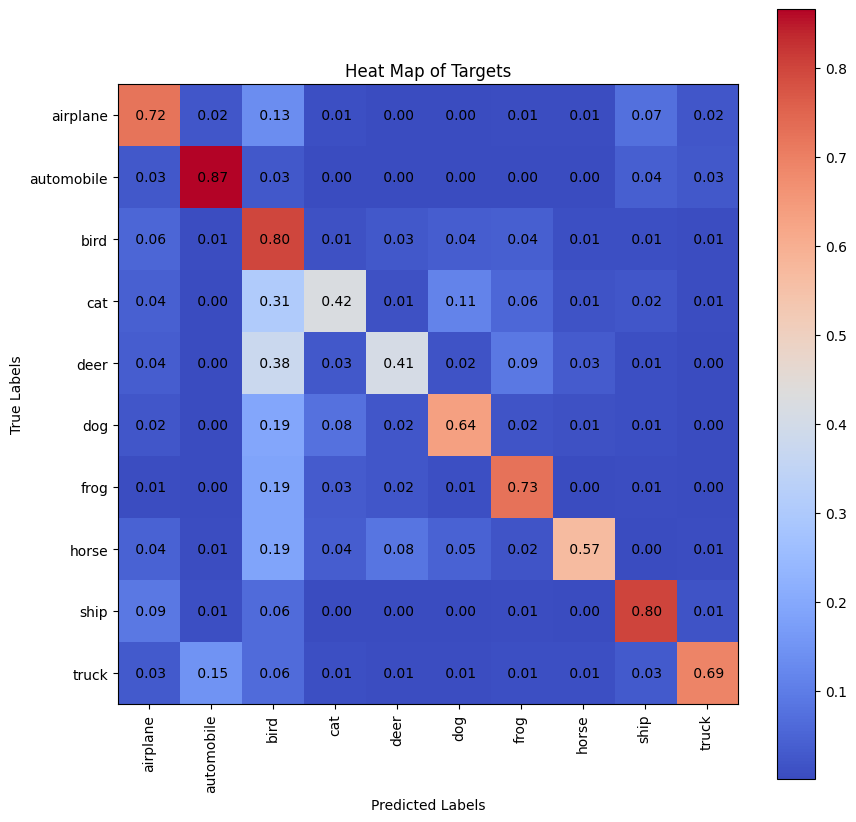

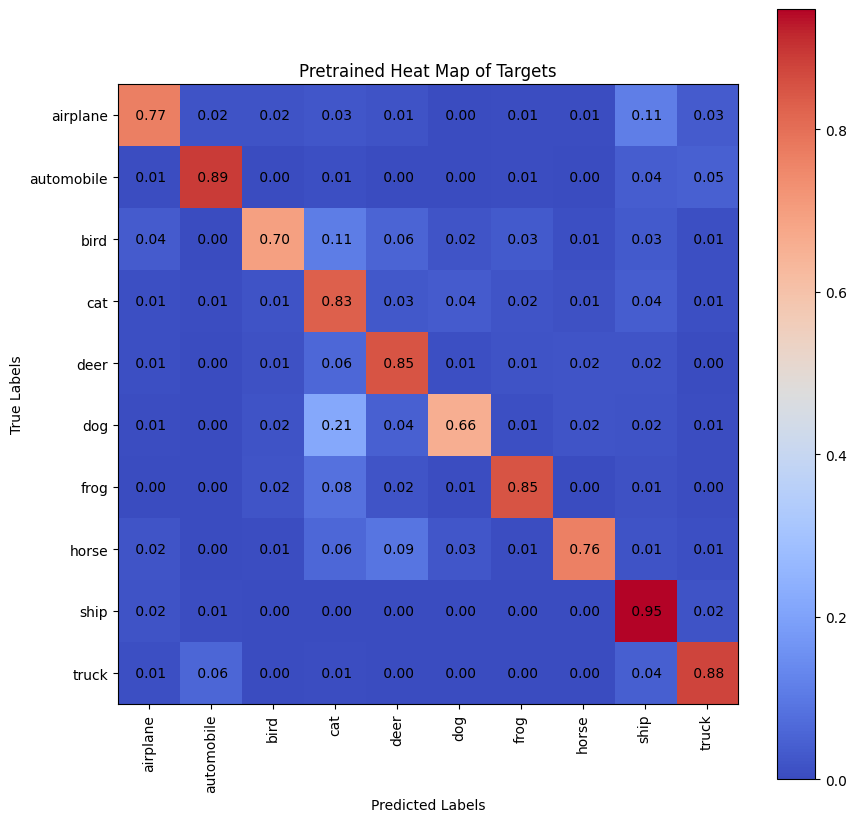

In [20]:
PlotHeatMap(heatmap_arr, 'Heat Map of Targets', targets, '.\images\heatmap.png')
PlotHeatMap(pretrain_heatmap_arr, 'Pretrained Heat Map of Targets', targets, '.\images\pretrain_heatmap.png')

In [21]:
accuracy_arr = np.diagonal(heatmap_arr)
print('Self Model')
for a, b in zip(targets, accuracy_arr):
    print(f'Accuracy of {a: >10s}: {b}')
print('\n\n')
pretrain_accuracy_arr = np.diagonal(pretrain_heatmap_arr)
print('Pretrained Model')
for a, b in zip(targets, pretrain_accuracy_arr):
    print(f'Accuracy of {a: >10s}: {b}')

Self Model
Accuracy of   airplane: 0.724
Accuracy of automobile: 0.866
Accuracy of       bird: 0.798
Accuracy of        cat: 0.422
Accuracy of       deer: 0.408
Accuracy of        dog: 0.636
Accuracy of       frog: 0.726
Accuracy of      horse: 0.568
Accuracy of       ship: 0.801
Accuracy of      truck: 0.692



Pretrained Model
Accuracy of   airplane: 0.769
Accuracy of automobile: 0.89
Accuracy of       bird: 0.696
Accuracy of        cat: 0.826
Accuracy of       deer: 0.851
Accuracy of        dog: 0.659
Accuracy of       frog: 0.85
Accuracy of      horse: 0.763
Accuracy of       ship: 0.948
Accuracy of      truck: 0.876


In [22]:
mask = np.ones(pretrain_heatmap_arr.shape, dtype=bool)
np.fill_diagonal(mask, 0)
max_value = pretrain_heatmap_arr[mask].max()
i, j = np.where(pretrain_heatmap_arr == max_value)
print(f'Most misclassifcations occur when true class is {idx_to_class[i[0]]} and predicted class is {idx_to_class[j[0]]}')
print(f'The most accurately predicted class is ship.')

Most misclassifcations occur when true class is dog and predicted class is cat
The most accurately predicted class is ship.


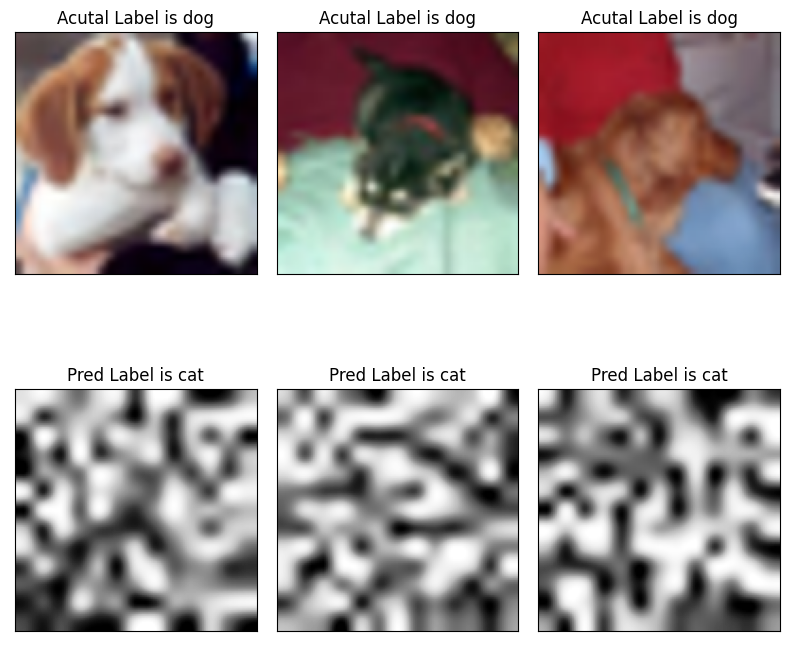

In [50]:
fig, axs = plt.subplots(2,3, figsize = (8, 8))
total = 0
for idx, (a, b) in enumerate(zip(true_targets, pretrain_predicted_targets)):
    true_class = idx_to_class[a]
    if true_class in ['dog']:
        if idx_to_class[b] == 'cat':
            img = testset.data[idx]
            img = Image.fromarray(img)
            img = img.resize((128, 128))
            axs[0, total].imshow(img)
            axs[0, total].set_xticks([])
            axs[0, total].set_yticks([])
            axs[0, total].set_title(f'Acutal Label is {true_class}')
            img2 = full_pred[idx][b]
            img2 = torchvision.transforms.ToPILImage()(img2)
            img2 = img2.resize((128, 128))
            axs[1, total].imshow(img2, cmap = 'Greys')
            axs[1, total].set_xticks([])
            axs[1, total].set_yticks([])
            axs[1, total].set_title(f'Pred Label is {idx_to_class[b]}')
            total += 1            
    if total > 2:
        break
fig.tight_layout()

In [49]:
final_layer_avg_img = [[] for _ in range(10)]
for i, lab in enumerate(true_targets):
    img = full_pred[i][lab]
    img = img.reshape(1, img.shape[0], img.shape[1]) # Do this to make vstack work.
    final_layer_avg_img[lab].append(img)

for i in range(len(final_layer_avg_img)):
    final_layer_avg_img[i] = torch.vstack(final_layer_avg_img[i])
    final_layer_avg_img[i] = torch.mean(final_layer_avg_img[i], 0)

torch.Size([13, 13])

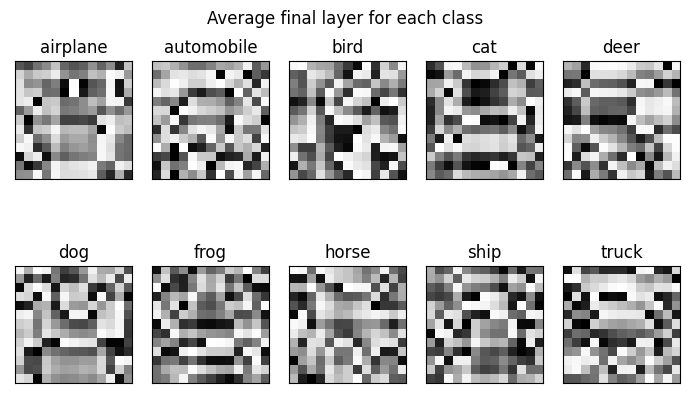

In [61]:
fig, axs = plt.subplots(2, 5, figsize = (7,7))
for i, img in enumerate(final_layer_avg_img):
    img = torchvision.transforms.ToPILImage()(img)
    axs[i//5,i%5].imshow(img, cmap='Greys')
    axs[i//5,i%5].set_xticks([])
    axs[i//5,i%5].set_yticks([])
    axs[i//5,i%5].set_title(idx_to_class[i])
    fig.suptitle('Average final layer for each class', y = 0.78)
    fig.tight_layout()

#__Write analysis here__

The pretrained model was able to predict ships most accurately. The non-pretrained model was able to predict automobile's most accurately. 

Most misclassifcations occur when true class is dog and predicted class is cat in the pretrained model. 
Most misclassifcations occur when true class is deer and predicted class is bird in the non-pretrained model. 

Based on the heat map. It appears that the classifier has difficulties distinguishing between different animals. In particular it seems to struggle with distinguishing dogs and cats. On the flip side it appears to be pretty good at distinguishing animals from vehicles. This is most likely due to animals having similar features and vehicles having similar features. For instance, in addition to mixing up cats and dogs, there is also a slightly less "blue" value for "truck" row and "automobile" column of the pretrained model heatmap. Trucks and automobiles share many characteristics so this is in line with the theory that the model has difficulty distinguishing images that have similar features since trucks are a type of automobile.

#__Task 6 Create your own model(10 Points OR 10 Points + 10 Bonus Points)__

You have two options, and this task is open ended. 

Make your own model. Name the model class with your name(e.g. YoungJeNet). Briefly describe how you organized your model architecture and pipeline, and why you proposed such architecture (feel free to take inspiration from common architectures, and please reference any tutorials/guides that you use). Feel free to use your designed DataLoader and feel free to weight shift from any different model. Also feel free to use your training and test loop.
With your defined model, run your pipeline on a new dataset and provide graphs of training accuracy and training loss, and report final accuracy.

Do NOT just bring pretrained model: Like model=some_kind_of_pretrained_model(pretrain=True)

For your new dataset, choose one of the following options:
1. (10 Points) One of the following standard datasets: CIFAR10, PASCAL VOC, CALTECH256, or ImageNet2012.

2. (10 Points + 10 Bonus Points) Find a dataset of your interest in biology. We are giving bonus points here because you need to describe further about your dataset and may need to work more with Dataloader.

Please be mind that if you choose 2, this should not be part of your project.

Your score will be determined based on 1. Description of dataset 2. Clearly stated idea and correctly implemented the idea. 3. Not too low accuracy. Please be aware that accuracy is not the only criterion here.

#__Data set from https://www.kaggle.com/datasets/paultimothymooney/blood-cells?resource=download__

The dataset contained 20,000 augmented (stretched and rotated) images of blood cells. The data was already split such that there are 10,000 training images and 10,000 testing images. I processed the data into pickle files for faster reading into memory (not shown in below code).
There were 4 different cell types present in this image data set: Eosinophil, Lymphocyte, Monocyte, and Neutrophil. Each image was a 240x320 RGB image. The distribution of each cell type is about equal (25%) for each of the cell types in both the training and testing data.

The goal was to create a neural network that could predict the cell type of the augmented images.

Since the provided images are already augmented, I did not do any augmenting transformations to the dataset other than normalizing.

For the model, I decided to base it off of the AlexNet model we used above since it was a readily available model structure. I modified the kernel size and stride size of some of the layers so that the "image" size of each layer would be around the same as what we used above and so that the final layer would be a 13x13 'image' for each class.

I ended up training the model 2 times. Once in a separate python file and once from this notebook. (For some reason the model was much more accurate the first time I trained it from the separate python file even though I set the torch seed). So I will make plots and analyze both trained models.

In [4]:
#Your Model
# IMSHAPE is (240, 320, 3)
class MyModel(nn.Module):
    def __init__(self, num_classes=4):
        super(MyModel, self).__init__()
        self.features=nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=(9, 12), stride=(3, 4), padding=(2, 2)),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size=(3, 3), stride=(2, 2), dilation=(1, 1), ceil_mode=False),
            nn.Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
            nn.ReLU(inplace= True),
            nn.MaxPool2d(kernel_size=(3, 3), stride=(2, 2), dilation=(1, 1), ceil_mode=False),
            nn.Conv2d(192, 384, kernel_size=(5, 5), stride=(1, 1)),
            nn.ReLU(inplace= True),
            nn.Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace= True),
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace= True)
        )
        
        self.classifier=nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1)),
            nn.ReLU(inplace = True),
            nn.Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1)),
            nn.ReLU(inplace = True),
            nn.Conv2d(256, 4, kernel_size=(1, 1), stride=(1, 1))
        )
        
        #We will give this initialization for you
        for neuron in self.features:
            if isinstance(neuron,nn.Conv2d):
                nn.init.xavier_uniform_(neuron.weight)

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [5]:
class CellType(Dataset):
    # Image dimensions 240 x 320 x 3
    def __init__(self, data, targets, class_to_idx, transform=None):
      
        self.data = data
        self.data = self.data.reshape((-1, 3, 240, 320))
        self.data = self.data.transpose((0, 2, 3, 1))

        self.targets = targets
        self.class_to_idx = class_to_idx
        self.transform = transform

    def __getitem__(self, idx):
        img = self.data[idx]
        img = Image.fromarray(img)
        if self.transform:
            img = self.transform(img)
        target = self.targets[idx]
        return img, target

    def __len__(self):
        return len(self.data)

root = './archive'
with open(os.path.join(root, 'traindata'), 'rb') as f:
    temp = pickle.load(f, encoding = 'latin1')
    traindata = temp['data']
    trainlabels = temp['labels']
    class_to_idx = temp['class_to_idx']

with open(os.path.join(root, 'testdata'), 'rb') as f:
    temp = pickle.load(f, encoding = 'latin1')
    testdata = temp['data']
    testlabels = temp['labels']

In [6]:
# No need to resize because images are already relatively large.
train_transform = Compose([
    ToTensor(),
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transform = Compose([
    ToTensor(),
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
    
trainset = CellType(traindata, trainlabels, class_to_idx, train_transform)
testset = CellType(testdata, testlabels, class_to_idx, test_transform)

# Must set num_workers to 0 because multiprocessing doesn't work on windows with jupyter notebooks.
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 64, shuffle = True, num_workers = 0)
testloader = torch.utils.data.DataLoader(testset, batch_size = 64, shuffle = False, num_workers = 0) 

In [7]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    train_loss, correct = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y_one_hot = torch.nn.functional.one_hot(y, num_classes = 4)
        y_one_hot = y_one_hot.to(device).float()
        
        # Compute prediction error
        pred = model(X)

        final_layer=nn.MaxPool2d((pred.size(2),pred.size(3)))
        pred=final_layer(pred)
        pred=torch.reshape(pred,(-1,4))#(-1,10)
        pred=F.sigmoid(pred)

        loss = loss_fn(pred, y_one_hot)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()       

        if batch % 100 == 0:
            loss_, current = loss.item(), (batch + 1) * len(X)
            print(f"\rloss: {loss_:>7f}  [{current:>5d}/{size:>5d}]", end = '')
            
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        train_loss += loss.item()

    train_loss /= num_batches
    correct /= size
    return correct, train_loss

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_one_hot = torch.nn.functional.one_hot(y, num_classes = 4)
            y_one_hot = y_one_hot.to(device).float()
            pred = model(X)

            final_layer=nn.MaxPool2d((pred.size(2),pred.size(3)))
            pred=final_layer(pred)
            pred=torch.reshape(pred,(-1,4))#(-1,10)
            pred=F.sigmoid(pred)

            test_loss += loss_fn(pred, y_one_hot).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            
    test_loss /= num_batches
    correct /= size
    print(f"\rTest Error: \t Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct, test_loss


def GetPredictions(model, dataloader):
    '''
    Returns 2 lists
    first list is the weight of each class the model predicts for each image
    second list is the final "layer" of the model for each iamge.
    '''
    target_prob = [] # List to hold predictions
    full_pred = [] # list to hold images of Final "layer" 
    model.eval()
    with torch.no_grad():
        for X, y in testloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            full_pred.extend(pred)
            final_layer=nn.MaxPool2d((pred.size(2),pred.size(3)))
            pred=final_layer(pred)
            pred=torch.reshape(pred,(-1,4))#(-1,10)
            pred=F.sigmoid(pred)
            target_prob.append(pred)
    target_prob = torch.vstack(target_prob)
    return target_prob, full_pred

In [ ]:

device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")
model = MyModel().to(device)

num_iter=20
loss_fn=nn.BCELoss()
optimizer=torch.torch.optim.SGD(model.parameters(),lr=0.1)
scheduler = ReduceLROnPlateau(optimizer, 'min')

record_dict = {
'train_accuracy': [],
'train_loss': [],
'test_accuracy': [],
'test_loss': []
}

start = time.time()
for t in range(num_iter):
    print(f"Epoch {t+1}\t{time.time()-start: 0.2f}s\n----------------------------------")
    tr_accuracy, tr_loss = train(trainloader, model, loss_fn, optimizer)
    record_dict['train_accuracy'].append(tr_accuracy)
    record_dict['train_loss'].append(tr_loss)

    ts_accuracy, ts_loss = test(testloader, model, loss_fn)
    record_dict['test_accuracy'].append(ts_accuracy)
    record_dict['test_loss'].append(ts_loss)
    
    scheduler.step(ts_loss)

    torch.save(record_dict, './6_record.pt')
    torch.save(model.state_dict(), './6_model.pt')
    torch.save(optimizer.state_dict(), './6_optimizer.pt')


In [8]:
record1 = torch.load('./data/6_record_final.pt') # Model from first time I trained via python script (not from this notebook)
record2 = torch.load('./6_record.pt') # Results from training in jupyter notebook.

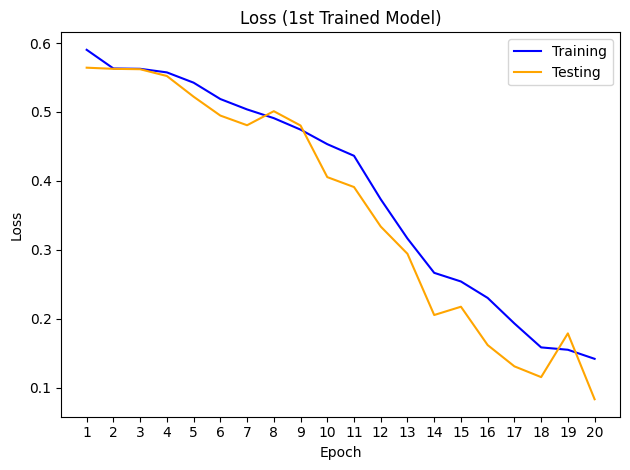

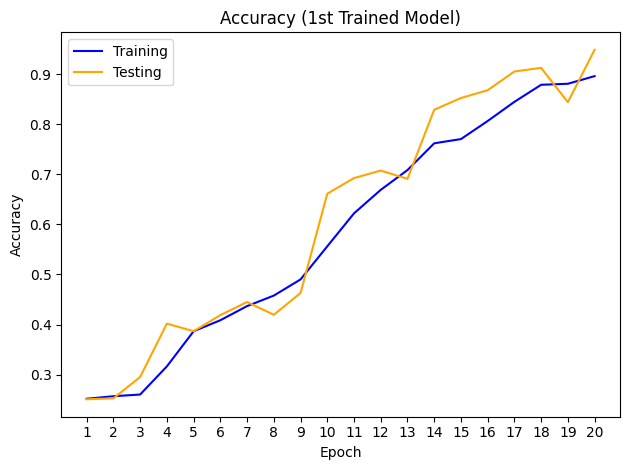

In [ ]:
train_loss = record1['train_loss']
train_acc = record1['train_accuracy']
test_loss = record1['test_loss']
test_acc = record1['test_accuracy']
PlotCurvesTrainTest(train_loss, test_loss, ['Training', 'Testing'], 'Loss (1st Trained Model)', 'Loss')
PlotCurvesTrainTest(train_acc, test_acc, ['Training', 'Testing'], 'Accuracy (1st Trained Model)', 'Accuracy')

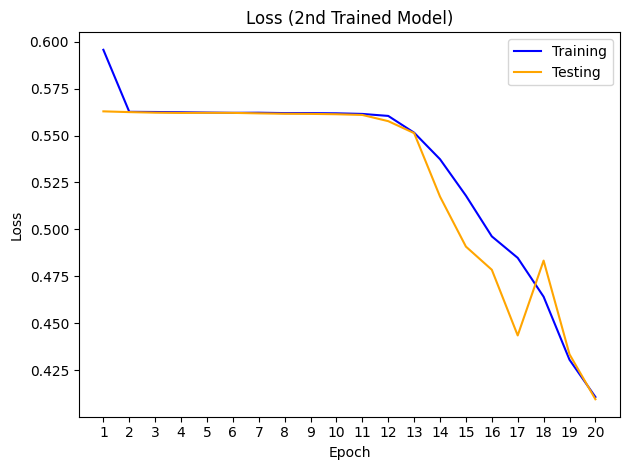

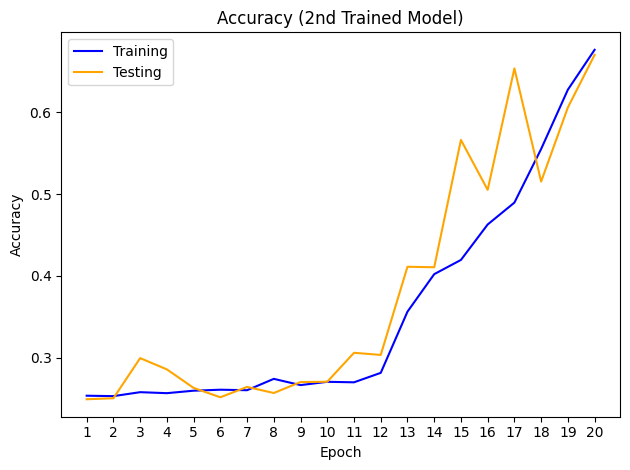

In [ ]:
train_loss = record2['train_loss']
train_acc = record2['train_accuracy']
test_loss = record2['test_loss']
test_acc = record2['test_accuracy']
PlotCurvesTrainTest(train_loss, test_loss, ['Training', 'Testing'], 'Loss (2nd Trained Model)', 'Loss')
PlotCurvesTrainTest(train_acc, test_acc, ['Training', 'Testing'], 'Accuracy (2nd Trained Model)', 'Accuracy')

In [9]:
num_targets = len(testset.class_to_idx)
true_targets = testset.targets
idx_to_class = {}
for key, val in testset.class_to_idx.items():
    idx_to_class[val] = key
targets = [idx_to_class[i] for i in range(len(testset.class_to_idx))]

In [12]:
model1 = MyModel().to(device)
model2 = MyModel().to(device)
model1.load_state_dict(torch.load('./data/6_model_final.pt'))
model2.load_state_dict(torch.load('./6_model.pt'))

<All keys matched successfully>

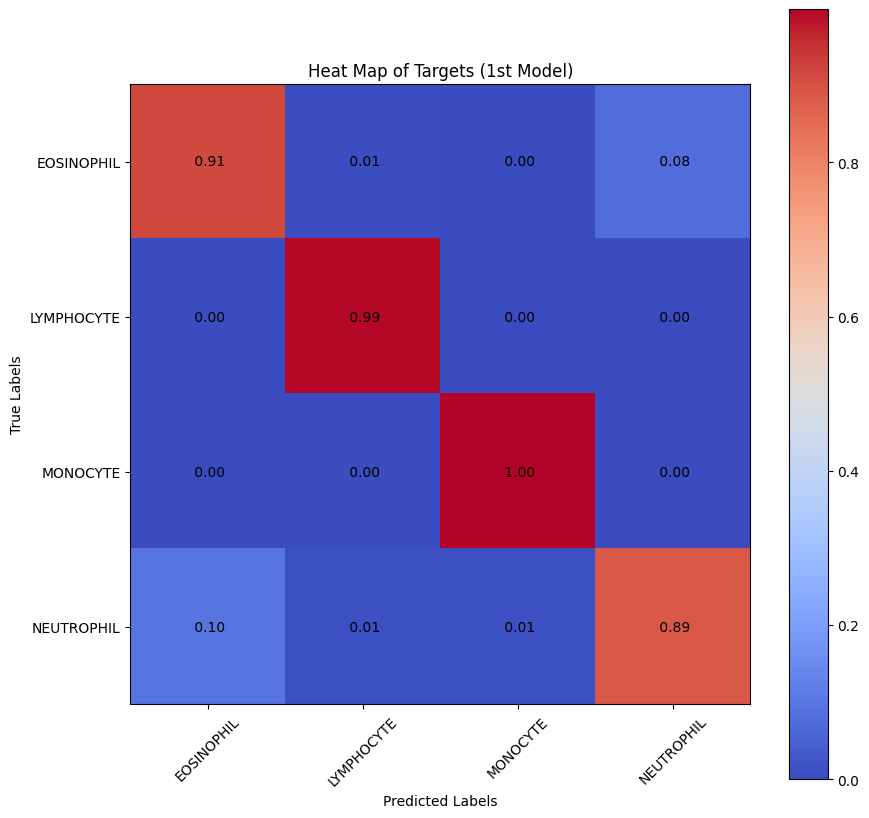

In [13]:
target_prob_1, full_pred_1 = GetPredictions(model1, testloader)
predicted_targets_1 = target_prob_1.argmax(1).tolist()

heatmap_arr_1 = np.zeros((num_targets, num_targets))
num_iter = 0
for i, j in zip(true_targets, predicted_targets_1):
    num_iter += 1
    heatmap_arr_1[i,j] += 1
heatmap_arr_1 /= heatmap_arr_1.sum(axis = 1)[:, np.newaxis]

PlotHeatMap(heatmap_arr_1, 'Heat Map of Targets (1st Model)', targets)

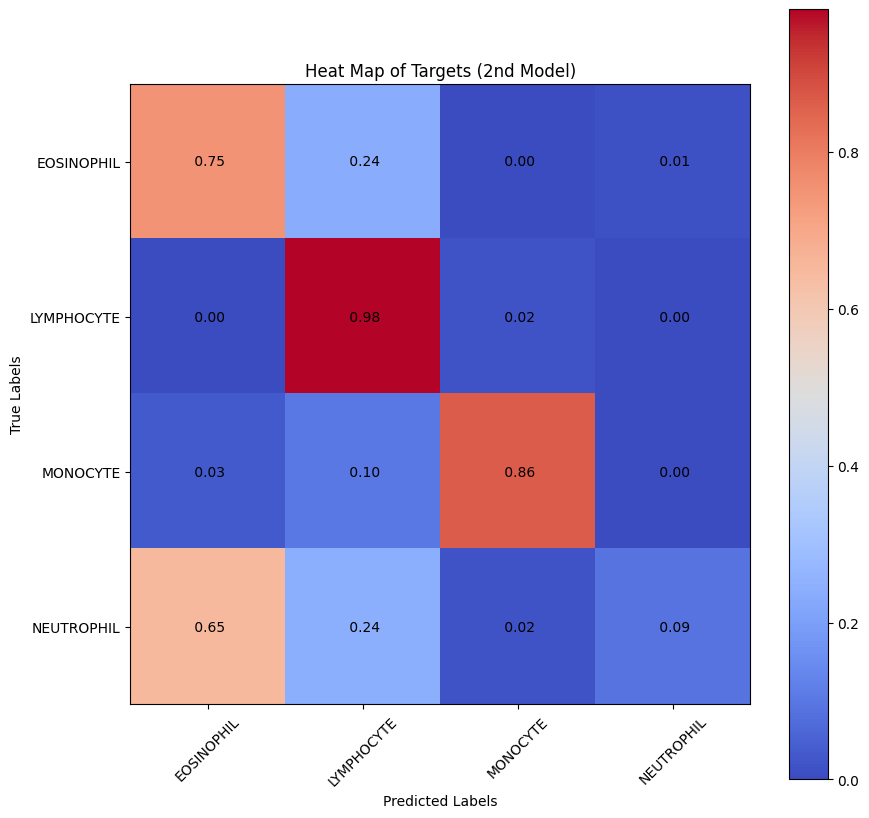

In [15]:
target_prob_2, full_pred_2 = GetPredictions(model2, testloader)
predicted_targets_2 = target_prob_2.argmax(1).tolist()

heatmap_arr_2 = np.zeros((num_targets, num_targets))
num_iter = 0
for i, j in zip(true_targets, predicted_targets_2):
    num_iter += 1
    heatmap_arr_2[i,j] += 1
heatmap_arr_2 /= heatmap_arr_2.sum(axis = 1)[:, np.newaxis]

PlotHeatMap(heatmap_arr_2, 'Heat Map of Targets (2nd Model)', targets)

#__The most mistaken task is mislabeling neutrophils as eosinophils so I'll look at those.__

FOR FIRST TRAINED MODEL


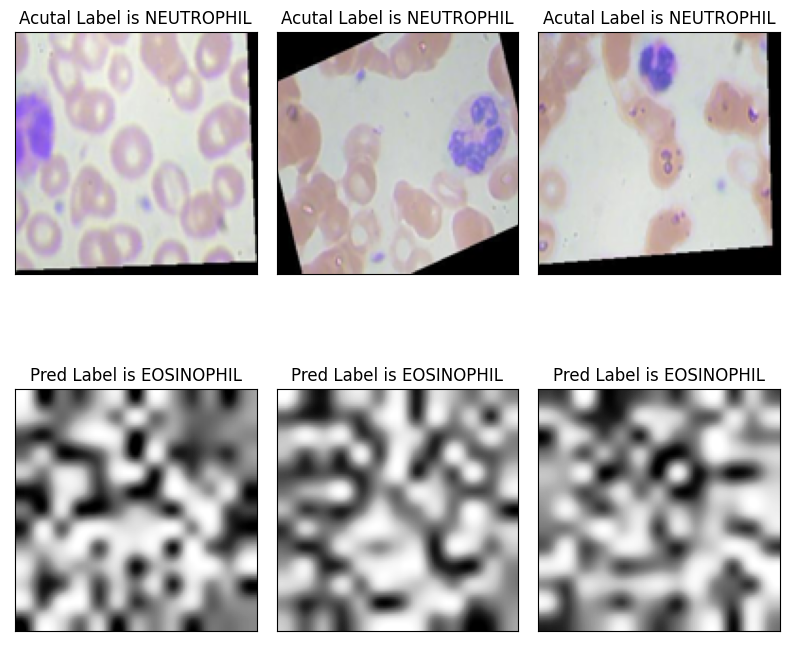

In [18]:
print('FOR FIRST TRAINED MODEL')
fig, axs = plt.subplots(2,3, figsize = (8, 8))
total = 0
for idx, (a, b) in enumerate(zip(true_targets, predicted_targets_1)):
    true_class = idx_to_class[a]
    if true_class == 'NEUTROPHIL':
        if idx_to_class[b] == 'EOSINOPHIL':
            img = testset.data[idx]
            img = Image.fromarray(img)
            img = img.resize((128, 128))
            axs[0, total].imshow(img)
            axs[0, total].set_xticks([])
            axs[0, total].set_yticks([])
            axs[0, total].set_title(f'Acutal Label is {true_class}')
            img2 = full_pred_1[idx][b]
            img2 = torchvision.transforms.ToPILImage()(img2)
            img2 = img2.resize((128, 128))
            axs[1, total].imshow(img2, cmap = 'Greys')
            axs[1, total].set_xticks([])
            axs[1, total].set_yticks([])
            axs[1, total].set_title(f'Pred Label is {idx_to_class[b]}')
            total += 1            
    if total > 2:
        break
fig.tight_layout()

FOR SECOND TRAINED MODEL


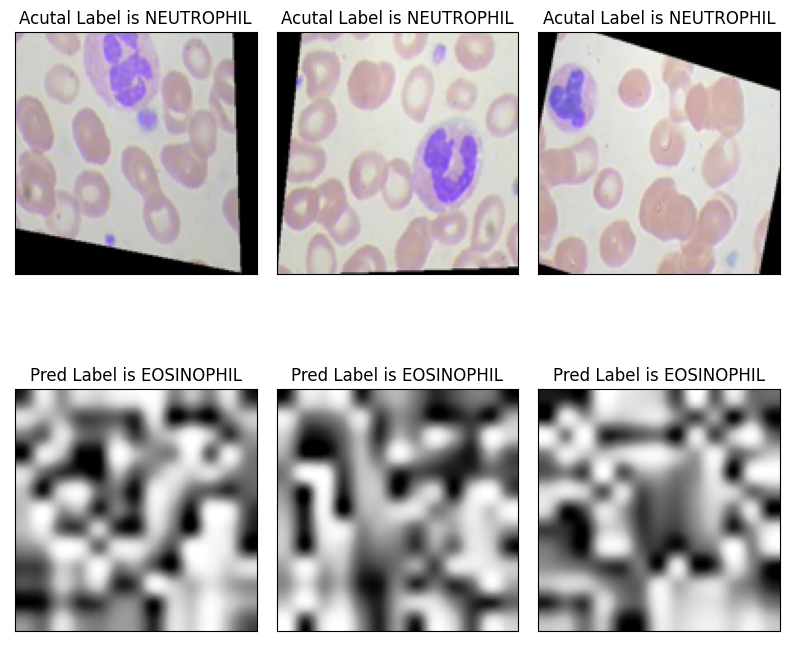

In [19]:
print('FOR SECOND TRAINED MODEL')
fig, axs = plt.subplots(2,3, figsize = (8, 8))
total = 0
for idx, (a, b) in enumerate(zip(true_targets, predicted_targets_2)):
    true_class = idx_to_class[a]
    if true_class == 'NEUTROPHIL':
        if idx_to_class[b] == 'EOSINOPHIL':
            img = testset.data[idx]
            img = Image.fromarray(img)
            img = img.resize((128, 128))
            axs[0, total].imshow(img)
            axs[0, total].set_xticks([])
            axs[0, total].set_yticks([])
            axs[0, total].set_title(f'Acutal Label is {true_class}')
            img2 = full_pred_2[idx][b]
            img2 = torchvision.transforms.ToPILImage()(img2)
            img2 = img2.resize((128, 128))
            axs[1, total].imshow(img2, cmap = 'Greys')
            axs[1, total].set_xticks([])
            axs[1, total].set_yticks([])
            axs[1, total].set_title(f'Pred Label is {idx_to_class[b]}')
            total += 1            
    if total > 2:
        break
fig.tight_layout()

In [50]:
# Looking at 'image' sizes after each transform to try and choose values for kernel size, stride and padding.
# I'm going to try and match the sizes created by AlexNet. So not very much will change.
temp = trainset[0][0]
print(temp.shape)
temp = nn.Conv2d(3, 64, kernel_size=(9, 12), stride=(3, 4), padding=(2, 2))(temp)
print(temp.shape)
temp = nn.MaxPool2d(kernel_size=(3, 3), stride=(2, 2), dilation=(1, 1), ceil_mode=False)(temp)
print(temp.shape)
temp = nn.Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))(temp)
print(temp.shape)
temp = nn.MaxPool2d(kernel_size=(3, 3), stride=(2, 2), dilation=(1, 1), ceil_mode=False)(temp)
print(temp.shape)
temp = nn.Conv2d(192, 384, kernel_size=(5, 5), stride=(1, 1))(temp)
print(temp.shape)
temp = nn.Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))(temp)
print(temp.shape)
temp = nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))(temp)
print(temp.shape)
temp = nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))(temp)
print(temp.shape)
temp = nn.Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))(temp)
print(temp.shape)
temp = nn.Conv2d(256, 4, kernel_size=(1, 1), stride=(1, 1))(temp)
print(temp.shape)

torch.Size([3, 240, 320])
torch.Size([64, 79, 79])
torch.Size([64, 39, 39])
torch.Size([192, 39, 39])
torch.Size([192, 19, 19])
torch.Size([384, 15, 15])
torch.Size([256, 15, 15])
torch.Size([256, 15, 15])
torch.Size([256, 13, 13])
torch.Size([256, 13, 13])
torch.Size([4, 13, 13])


(Option) For your career, we encourage you to upload your work on Github. Github is a repository for programmers. This repo can be useful to your future career, especially if you aim to work in a computational job: provide your Github link to recruiter/research POI. By doing so, you can show your recruiter/research POI that you have fundamental ability to work with deep learning and being able to code Pytorch.

Congratulations! Now you understand the basic flow of deep learning workflow. CMU provides a variety of deep learning courses, so we recommend taking any of them if you are interested or strengthen your knowledge and skills in deep learning. If you want to learn general deep learning, consider 11-685 Introduction to Deep learning. Be careful that this course is very hectic. LTI and RI offer domain specific deep learning courses(such as Natural Language Processing, Visual Learning and Recognition). If you want to know deep learning theory, consider 10-707. Please be aware that what we've covered in this assignment is very basic: this is going to be assignment 0 for other deep learning courses. However, we believe that this assignment will work as a immigration assignment to deep learning.